We all use LinkedIn to make connections with professionals in our industry or even from any other industry too. On LinkedIn, we see only a list of our connections, so it’s hard to visualize the entire network of your connections. I tried to apply my python skill in Data Science to explore my connections on  LinkedIn and find out some interesting information and visualize it in the form of graph. 

Graphs are one of the most important data structures that is applied in many real-world solutions. One of them is social networks. This really looks exciting. We will be creating a network that connects you to all the companies from your connections.

### Download data:
Here’s a step-by-step guide for getting a copy of your data on LinkedIn:
- Click on your Me drop down in the homepage
- Head over to “Settings & Privacy”
- Click on “Get a copy of your data”

Check connections only, and hit “Request archive”. After a few minutes, you should get the archive file in your email.

In [1]:
!pip install pyjanitor pyvis --quiet

In [2]:
import pandas as pd
import datetime
import janitor                                     # Clean APIs for data cleaning. Python implementation of R package Janitor
from pyvis import network as net                   # Visualizing network graph
import networkx as nx                              # Create network graph with Python
from IPython.core.display import display, HTML

In [3]:
connection_data = pd.read_csv("Connections.csv", skiprows=3)

In [4]:
connection_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3337 entries, 0 to 3336
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   First Name     3160 non-null   object
 1   Last Name      3160 non-null   object
 2   Email Address  92 non-null     object
 3   Company        3050 non-null   object
 4   Position       3075 non-null   object
 5   Connected On   3337 non-null   object
dtypes: object(6)
memory usage: 156.5+ KB


## Data Cleaning

In [5]:
df = (
    connection_data
    .clean_names()                                              # remove spacing and capitalization
    .drop(columns=['first_name', 'last_name', 'email_address']) # drop for privacy
    .dropna(subset=['company', 'position'])                     # drop missing values in company and position
    .to_datetime('connected_on', format='%d %b %Y')
  )
df.head()

,company,position,connected_on
0,Factspan Inc.,Senior Director Talent Acquisition,2021-11-09
1,"eureQa, LLC",Manager Human Resources,2021-11-09
2,Siemens Limited. Energy Sector,Manager,2021-11-07
3,Verisk,Senior Data Scientist-I,2021-11-04
4,Entropik Tech,Human Resources Manager,2021-11-03


## Simple EDA

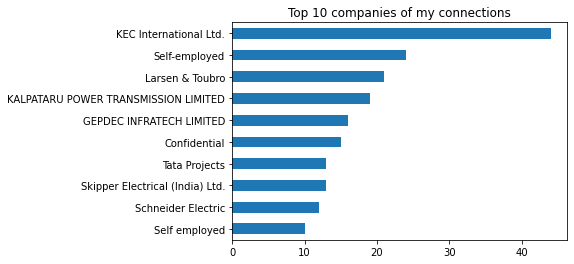

In [6]:
df['company'].value_counts().head(10).plot(kind="barh", title= "Top 10 companies of my connections").invert_yaxis(); 

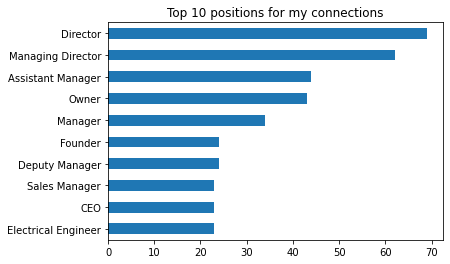

In [7]:
df['position'].value_counts().head(10).plot(kind="barh", title= "Top 10 positions for my connections").invert_yaxis();

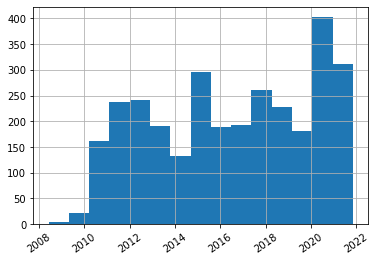

In [8]:
df['connected_on'].hist(xrot=35, bins=15);

### Remove Self-employed, Confidential like entries:
Notice there is a “Self-employed” category in our company column, digging more into the data we will see that there are many more such entries which are not actual company name. We’ll be removing that for the sake of only having company names.

In [9]:
pattern = "freelance|self-employed|Self employed|Confidential"
df = df[~df['company'].str.contains(pattern, case=False)]

## Aggregate sum of connections for companies

In [10]:
df_company = df['company'].value_counts().reset_index()
df_company.columns = ['company', 'count']
df_company = df_company.sort_values(by="count", ascending=False)
df_company.head(10)

,company,count
0,KEC International Ltd.,44
1,Larsen & Toubro,21
2,KALPATARU POWER TRANSMISSION LIMITED,19
3,GEPDEC INFRATECH LIMITED,16
4,Tata Projects,13
5,Skipper Electrical (India) Ltd.,13
6,Schneider Electric,12
7,Hitachi Energy,9
8,Tata Consultancy Services,8
9,Sterlite Power,8


## Aggregate sum of connections for positions

In [11]:
df_position = df['position'].value_counts().reset_index()
df_position.columns = ['position', 'count']
df_position = df_position.sort_values(by="count", ascending=False)
df_position.head(10)

,position,count
0,Director,67
1,Managing Director,60
2,Assistant Manager,44
3,Owner,42
4,Manager,32
5,Deputy Manager,24
6,Founder,24
7,Electrical Engineer,23
8,Sales Manager,23
9,Project Engineer,21


### Creating the network
Before we create our LinkedIn network, let’s start small, and figure out how PyVis and networkX work.

### Example of simple network

In [12]:
nt = net.Network(notebook=True)

g = nx.Graph()
g.add_node(0, label = "root") # intialize yourself as central node
g.add_node(1, label = "Company 1", size=10, title="info1")
g.add_node(2, label = "Company 2", size=40, title="info2")
g.add_node(3, label = "Company 3", size=60, title="info3")
g.add_edge(0, 1)
g.add_edge(0, 2)
g.add_edge(0, 3)

nt.from_nx(g)
nt.show('nodes.html')
display(HTML('nodes.html'))

First we create our network class which takes in a graph object in the end, and then save the network as a html.

To form our graph, we construct it with the Graph class, and then add nodes to it. The add_node function takes in a couple arguments. The number at the start are unique id’s, this allows us to connect them later on. We can also use the labels as ID’s as long as they are unique.

We can control the size by assigning integer values to the argument, and the title argument stands for the hover info.
Try clicking on one of the nodes, and hover over it. We can see that the strings we pass in is displayed!

In [13]:
print(f"number of nodes: {g.number_of_nodes()}")
print(f"number of edges: {g.number_of_edges()}")

number of nodes: 4
number of edges: 3


After we have our graphs, we can also get properties like number of nodes and edges.

In [17]:
for i, row in df_company.head(5).iterrows():
  print(row['company'] + "-" + str(row['count']))

KEC International Ltd.-44
Larsen & Toubro-21
KALPATARU POWER TRANSMISSION LIMITED-19
GEPDEC INFRATECH LIMITED-16
Tata Projects-13


### Reduce size of nodes:
Currently we have almost 2600 companies and over 2000 positions, that would make our network incredible large and slow down the visualization. To prevent that, we filter them down to counts of over 3 for company and 5 for position.

In [14]:
print(df_company.shape)
df_company_reduced = df_company.loc[df_company['count']>=3]
print(df_company_reduced.shape)

(2582, 2)
(58, 2)


In [15]:
print(df_position.shape)
df_position_reduced = df_position.loc[df_position['count']>=5]
print(df_position_reduced.shape)

(2014, 2)
(56, 2)


### Creating network for connections:

In [16]:
# initialize graph
g = nx.Graph()
g.add_node('root') # intialize yourself as central

# use iterrows to iterate through the data frame
for _, row in df_company_reduced.iterrows():

  # store company name and count
  company = row['company']
  count = row['count']

  title = f"<b>{company} – {count} connections</b>"
  positions = set([x for x in df[company == df['company']]['position']])
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)
  position_list = f"<ul>{positions}</ul>"

  hover_info = title + position_list

  g.add_node(company, size=count*2, title=hover_info, color='#3449eb')
  g.add_edge('root', company, color='grey')

# generate the graph
nt = net.Network(height='800px', width='1100px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('company_graph.html')
display(HTML('company_graph.html'))

In [17]:
# initialize graph
g = nx.Graph()
g.add_node('root') # intialize yourself as central

# use iterrows tp iterate through the data frame
for _, row in df_position_reduced.iterrows():

  count = f"{row['count']}"
  position= row['position']

  title = f"<b>{count} connections</b>"
  
  g.add_node(position, size=count, color='#3449eb', title=title)
  g.add_edge('root', position, color='grey')

# generate the graph
nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
nt.show('position_graph.html')
display(HTML('position_graph.html'))

## Publish to datapane

In [18]:
def read_html(name: str):
    import codecs
    f = codecs.open(name, 'r')
    return f.read()

In [20]:
#!pip install jupyter-client==6.1.5 datapane --quiet
import datapane as dp

In [44]:
# Signup usinn link and enter token id in next block of code.
# !datapane signup

In [21]:
!datapane login --token=''

Connected successfully to https://datapane.com as mgupta


In [22]:
report_company = dp.Report(dp.HTML(read_html('company_graph.html'))) 
report_position = dp.Report(dp.HTML(read_html('position_graph.html')))

report_company.upload(name='LinkedIn_connection_Company')
report_position.upload(name='LinkedIn_connection_Positions')

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/mgupta/reports/J35lWVA/linkedin-connection-company/) to view and share your report.

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/mgupta/reports/j3LQnv7/linkedin-connection-positions/) to view and share your report.